In [28]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel

In [29]:
df = pd.read_csv("../data/household_power_consumption.csv", sep=";")
print(df.head())

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


C:\Users\imade\AppData\Local\Temp\ipykernel_9852\1132520472.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/household_power_consumption.csv", sep=";")


In [30]:
# Combiner les colonnes Date et Time en une nouvelle colonne 'datetime'
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Définir 'datetime' comme index, si nécessaire
df.set_index('datetime', inplace=True)

# Afficher les premières lignes
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [31]:
df = df.drop(columns=['Date', 'Time'])


In [32]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')
df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce')

In [33]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
 
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [34]:
df_resample = df.resample('h').sum() 
df_resample.shape

(34589, 7)

In [35]:
values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.386208   0.177443   0.558893   0.382619        0.0   0.006820   
2   0.553644   0.103358   0.931236   0.549618        0.0   0.144652   
3   0.518286   0.110073   0.925886   0.510981        0.0   0.030869   
4   0.498217   0.096987   0.929217   0.490311        0.0   0.000000   
5   0.465887   0.099010   0.941472   0.459659        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.469451  0.553644  
2   0.782676  0.518286  
3   0.774169  0.498217  
4   0.778809  0.465887  
5   0.798917  0.335359  


In [36]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


In [37]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential


Epoch 1/20


c:\Users\imade\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 - 2s - 19ms/step - loss: 0.0190 - val_loss: 0.0117
Epoch 2/20
126/126 - 1s - 6ms/step - loss: 0.0123 - val_loss: 0.0104
Epoch 3/20
126/126 - 1s - 6ms/step - loss: 0.0113 - val_loss: 0.0096
Epoch 4/20
126/126 - 1s - 7ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 5/20
126/126 - 1s - 7ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 6/20
126/126 - 1s - 7ms/step - loss: 0.0103 - val_loss: 0.0088
Epoch 7/20
126/126 - 1s - 7ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 8/20
126/126 - 1s - 6ms/step - loss: 0.0102 - val_loss: 0.0088
Epoch 9/20
126/126 - 1s - 6ms/step - loss: 0.0101 - val_loss: 0.0088
Epoch 10/20
126/126 - 1s - 6ms/step - loss: 0.0102 - val_loss: 0.0087
Epoch 11/20
126/126 - 1s - 5ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 12/20
126/126 - 1s - 5ms/step - loss: 0.0102 - val_loss: 0.0087
Epoch 13/20
126/126 - 1s - 5ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 14/20
126/126 - 1s - 6ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 15/20
126/126 - 1s - 6ms/step - l

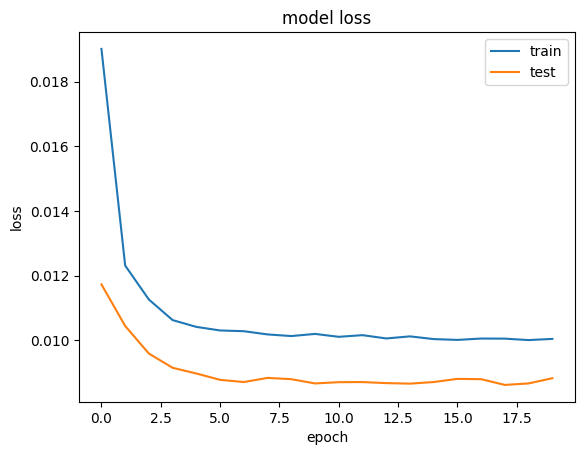

In [38]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [39]:
import numpy as np 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
     

808/808 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


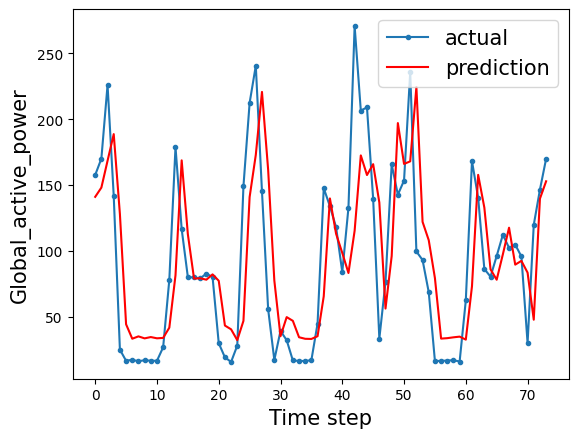

In [40]:
aa=[x for x in range(74)]
plt.plot(aa, inv_y[:74], marker='.', label="actual")
plt.plot(aa, inv_yhat[:74], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


In [41]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))
     

In [42]:
mae(inv_yhat,inv_y)

np.float64(28.621267803933357)

In [43]:
from sklearn.metrics import mean_squared_error,r2_score
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 36.980
